In [15]:

import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
from pypesto.ensemble import Ensemble
import os 

SEED=123456
np.random.seed(seed=SEED)
engine = eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

10


In [17]:
mrnaSBML = "hopfBifurcation_k38_model_sbml.xml" # name of sbml file
rr = roadrunner.RoadRunner(mrnaSBML)

In [18]:
# model system params
NFkB_SBML = "hopfBifurcation_k38_model_sbml.xml" # name of sbml file 
species = ['X1', 'X2', 'X3'] # names of observables in order from bngl file, also in smbl under "dependent variables / observables"

speciesID = ["S1", "S2", "S3"] # these are the IDs created from the sbml file 
time = 15 # t_end from bngl 
SPECIES_COLORS = ["tab:pink", "tab:blue", "tab:green"]
params = ["kA", "k2", "k3", "k4", "k5"] # names of parameters in order from bngl file 

# synthetic data params
gausNoise = 0.01 # 1% gausian noise, should it be 10% noise? i do 10 later
points = 10 # not sure yet 

# optimizaiton params 
logError = False

In [19]:
NFkB_SBML = "hopfBifurcation_k38_model_sbml.xml" # name of sbml file
rr = roadrunner.RoadRunner(NFkB_SBML) # uses libroadrunner to load the sbml file for the mRNA model 
# integrator is a numerical ODE solver
# abs and rel tolerance are parameters controlling error tolerence of the solution
rr.integrator.absolute_tolerance = 5e-12 # in absolute terms:  small value increases accuracy but slower
rr.integrator.relative_tolerance = 1e-12 # rel terms (proportion of value being calc): small val inc acc

# list of the true parameter values 
trueParams = [rr[params[0]], rr[params[1]], rr[params[2]], rr[params[3]], rr[params[4]]]


In [20]:
print(trueParams)

[3.8, 1.0, 1.0, 1.0, 1.0]


res         time,      [S1],     [S2],     [S3]
 [[        0,  0.357544, 0.520644, 0.205848],
  [ 0.100671,  0.450446, 0.491356, 0.224719],
  [ 0.201342,  0.569021, 0.467069, 0.251879],
  [ 0.302013,  0.720377, 0.448192, 0.289326],
  [ 0.402685,  0.913456, 0.435312, 0.339635],
  [ 0.503356,    1.1594, 0.429241, 0.406091],
  [ 0.604027,   1.47189, 0.431067, 0.492857],
  [ 0.704698,   1.86742, 0.442224, 0.605141],
  [ 0.805369,   2.36528, 0.464565, 0.749368],
  [  0.90604,   2.98716, 0.500445,  0.93332],
  [  1.00671,   3.75595, 0.552808,  1.16618],
  [  1.10738,   4.69316, 0.625261,  1.45842],
  [  1.20805,    5.8147, 0.722111,   1.8213],
  [  1.30872,   7.12413, 0.848338,  2.26604],
  [   1.4094,   8.60351,  1.00945,  2.80211],
  [  1.51007,   10.2026,  1.21117,  3.43491],
  [  1.61074,   11.8287,  1.45884,  4.16249],
  [  1.71141,   13.3429,  1.75661,  4.97197],
  [  1.81208,   14.5684,  2.10634,  5.83639],
  [  1.91275,   15.3169,  2.50638,  6.71361],
  [  2.01342,   15.4327,  2.9505

Text(0.5, 1.0, 'Hopf Bifurcation Model')

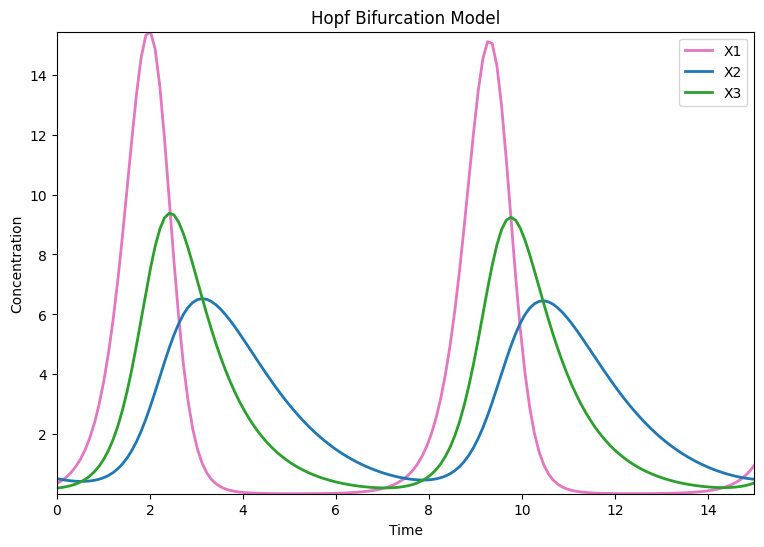

In [35]:
plt.figure(figsize=(9,6), dpi=100)
# simulates model from 0 to time with time*10 # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
res = rr.simulate(0, time, time*10)  
ts = res[:,0] # first col in res is the time points 
trajs = np.transpose(res[:,1:]) # rest of cols, so trajs has species as rows and time as cols bc transposed

print("res", res)
# print("trajs", trajs)

for label, color, traj in zip(species, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Hopf Bifurcation Model")

Text(0.5, 1.0, 'Hopf Bifurcation Model')

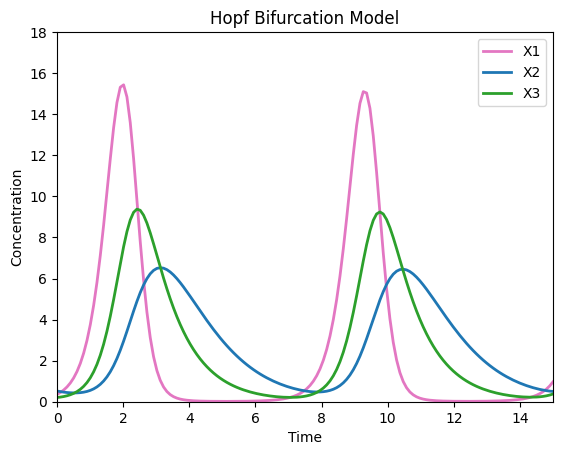

In [38]:
# use this one to edit figure

for label, color, traj in zip(species, SPECIES_COLORS, trajs):
    plt.plot(ts, traj, color=color, label=label, lw=2)

plt.legend()
plt.margins(x=0, y=0)
plt.ylim(0,18)
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.title("Hopf Bifurcation Model")

Generating Data

In [23]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
simData = rr.simulate(0, time, points)  
tsSim = simData[:,0] # first col in res is the time points 
print(tsSim)
trajsSim = simData[:,1:4] # the second col bc we want the mRNA concentration

print(trajsSim)

[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         11.66666667 13.33333333 15.        ]
 [[          1,        0,        0],
  [    16.7807,   4.2421,  10.6408],
  [  0.0273562,   6.1376,  3.51115],
  [ 0.00349292,  2.26832, 0.667428],
  [  0.0422627,  0.64346, 0.140281],
  [    2.32137, 0.353979, 0.692087],
  [    8.71865,  5.30244,  9.75362],
  [  0.0338152,  4.97426,   2.5348],
  [  0.0179569,  1.74554, 0.491058],
  [   0.357544, 0.520644, 0.205848]]



In [24]:
df = pd.DataFrame()
df['time'] = tsSim
df[['X1', 'X2', 'X3']] = trajsSim
df.to_csv('X_sim_data.csv', index=False)

Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

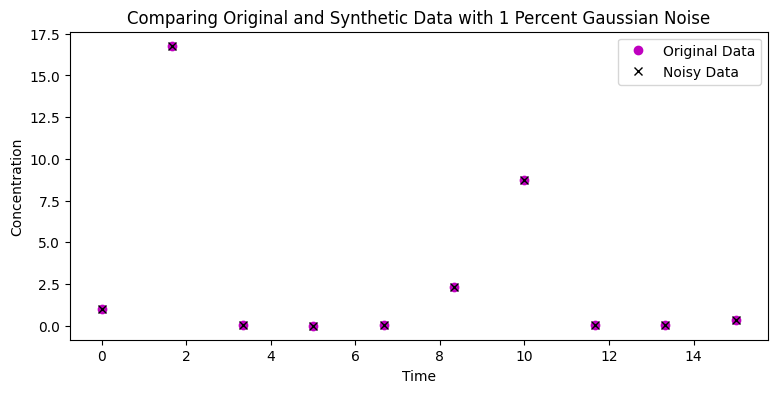

In [25]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(df['time'], df['X1'], 'om', label = "Original Data")
plt.plot(df['time'], df['X1'], 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 1 Percent Gaussian Noise')

With Gaussian Noise

In [26]:
def gaussianNoise(x, std, mean=0):
    
    gNoise = np.random.normal(mean, std, size = x.shape) # creates a gaussian dist the size of our data
    xNoise = x + gNoise # adds noise to our data

    # will return noisy data
    return xNoise 

In [27]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,1:4] # the second col bc we want the mRNA concentration
print(trajsNoise)

std = gausNoise * np.std(trajsNoise)
onePercentNoise = gaussianNoise(trajsNoise, std)

[ 0.          1.66666667  3.33333333  5.          6.66666667  8.33333333
 10.         11.66666667 13.33333333 15.        ]
 [[          1,        0,        0],
  [    16.7807,   4.2421,  10.6408],
  [  0.0273562,   6.1376,  3.51115],
  [ 0.00349292,  2.26832, 0.667428],
  [  0.0422627,  0.64346, 0.140281],
  [    2.32137, 0.353979, 0.692087],
  [    8.71865,  5.30244,  9.75362],
  [  0.0338152,  4.97426,   2.5348],
  [  0.0179569,  1.74554, 0.491058],
  [   0.357544, 0.520644, 0.205848]]



In [28]:
print(resNoise)

       time,       [S1],     [S2],     [S3]
 [[       0,          1,        0,        0],
  [ 1.66667,    16.7807,   4.2421,  10.6408],
  [ 3.33333,  0.0273562,   6.1376,  3.51115],
  [       5, 0.00349292,  2.26832, 0.667428],
  [ 6.66667,  0.0422627,  0.64346, 0.140281],
  [ 8.33333,    2.32137, 0.353979, 0.692087],
  [      10,    8.71865,  5.30244,  9.75362],
  [ 11.6667,  0.0338152,  4.97426,   2.5348],
  [ 13.3333,  0.0179569,  1.74554, 0.491058],
  [      15,   0.357544, 0.520644, 0.205848]]



In [29]:
df = pd.DataFrame()
df['time'] = tsNoise
df[['X1', 'X2', 'X3']] = onePercentNoise
df.to_csv('onePercNoise_hopf_data.csv', index=False)

In [30]:
trajsNoise

 [[          1,        0,        0],
  [    16.7807,   4.2421,  10.6408],
  [  0.0273562,   6.1376,  3.51115],
  [ 0.00349292,  2.26832, 0.667428],
  [  0.0422627,  0.64346, 0.140281],
  [    2.32137, 0.353979, 0.692087],
  [    8.71865,  5.30244,  9.75362],
  [  0.0338152,  4.97426,   2.5348],
  [  0.0179569,  1.74554, 0.491058],
  [   0.357544, 0.520644, 0.205848]]

In [31]:
trajsNoise[:,0]

[1.00000000e+00 1.67806707e+01 2.73562209e-02 3.49291701e-03
 4.22626795e-02 2.32136568e+00 8.71865472e+00 3.38152180e-02
 1.79569109e-02 3.57543856e-01]

/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_45642/2226330309.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "om" (-> color='m'). The keyword argument will take precedence.
  plt.plot(tsNoise, trajsNoise[:,0], 'om', label = "Original Data", color=SPECIES_COLORS[0])


Text(0.5, 1.0, 'X1 data with 1 Percent Gaussian Noise')

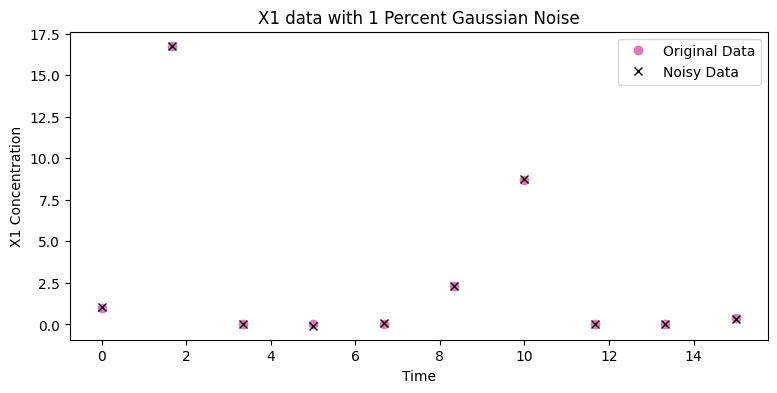

In [32]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise[:,0], 'om', label = "Original Data", color=SPECIES_COLORS[0])
plt.plot(tsNoise, onePercentNoise[:,0], 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('X1 Concentration')
plt.title('X1 data with 1 Percent Gaussian Noise')

/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_45642/1499310751.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "om" (-> color='m'). The keyword argument will take precedence.
  plt.plot(tsNoise, trajsNoise[:,1], 'om', label = "Original Data", color=SPECIES_COLORS[1])


Text(0.5, 1.0, 'X2 data with 1 Percent Gaussian Noise')

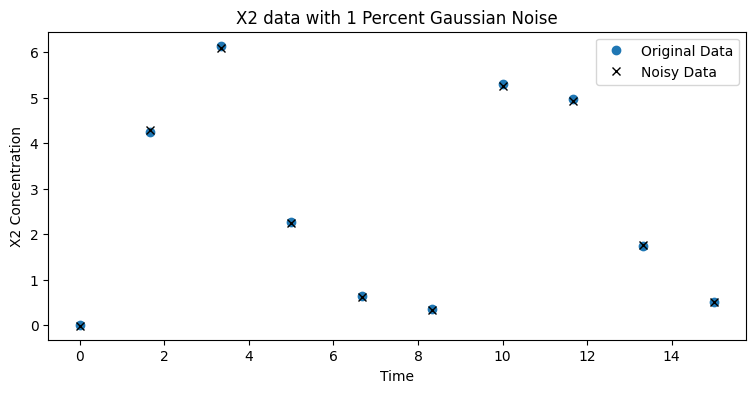

In [33]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise[:,1], 'om', label = "Original Data", color=SPECIES_COLORS[1])
plt.plot(tsNoise, onePercentNoise[:,1], 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('X2 Concentration')
plt.title('X2 data with 1 Percent Gaussian Noise')

/var/folders/jy/c63ddq7x061bb11h5xt4r2jr0000gn/T/ipykernel_45642/2956496062.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "om" (-> color='m'). The keyword argument will take precedence.
  plt.plot(tsNoise, trajsNoise[:,2], 'om', label = "Original Data", color=SPECIES_COLORS[2])


Text(0.5, 1.0, 'X3 data with 1 Percent Gaussian Noise')

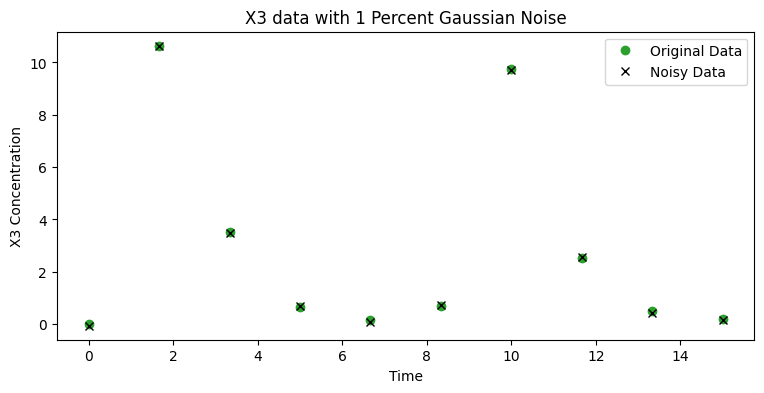

In [34]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise[:,2], 'om', label = "Original Data", color=SPECIES_COLORS[2])
plt.plot(tsNoise, onePercentNoise[:,2], 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('X3 Concentration')
plt.title('X3 data with 1 Percent Gaussian Noise')

10% Noise

In [42]:
rr.resetAll() # reset everything so we can start over and use our noisy data 

# simulates model from 0 to time with # of points
# in res: first col rep time points, other cols rep the trajectories (value over time) of species in model 
resNoise = rr.simulate(0, time, points)  
tsNoise = resNoise[:,0] # first col in res is the time points 
print(tsNoise)
trajsNoise = resNoise[:,1] # the second col bc we want the mRNA concentration
print(trajsNoise)

gausNoise10 = .1

std = gausNoise10 * np.std(trajsNoise)
tenPercentNoise = gaussianNoise(trajsNoise, std)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[1.00000000e+00 1.26668784e+01 7.39391952e+00 9.55498880e-02
 5.37558809e-03 3.49291701e-03 1.14736661e-02 8.89706675e-02
 1.01488992e+00 1.00086273e+01 8.71865472e+00 2.40597353e-01
 1.87450708e-02 1.36146814e-02 4.62294430e-02 3.57543856e-01
 3.69967338e+00 1.54575597e+01 1.63700478e+00 6.11930246e-02
 1.75602958e-02 3.30009017e-02 1.88004978e-01 1.78334612e+00
 1.26443308e+01 4.97962304e+00 1.59735556e-01 2.31202425e-02
 2.63326922e-02 1.14006324e-01 9.69597606e-01 8.50920607e+00
 9.79086736e+00 3.90595518e-01 3.22776747e-02 2.27061287e-02
 7.43797658e-02 5.57263177e-01 5.29800512e+00 1.38794532e+01
 9.41910665e-01 4.93360937e-02 2.12061276e-02 5.13110618e-02
 3.31306956e-01 3.17297989e+00 1.48796493e+01 2.20892758e+00
 8.39766227e-02 2.16750924e-02 3.74179806e-02]


Text(0.5, 1.0, 'Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

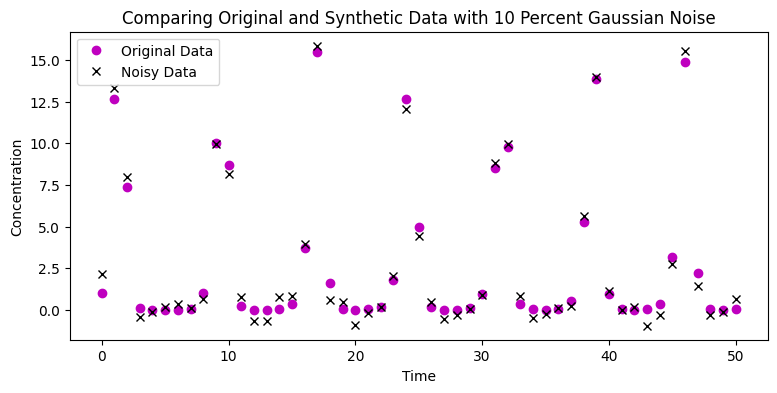

In [43]:
plt.figure(figsize=(9,4), dpi=100)
plt.plot(tsNoise, trajsNoise, 'om', label = "Original Data")
plt.plot(tsNoise, tenPercentNoise, 'kx', label = "Noisy Data")

plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Comparing Original and Synthetic Data with 10 Percent Gaussian Noise')

In [44]:
df = pd.DataFrame()
df['time'] = tsNoise
df['X1'] = tenPercentNoise
df.to_csv('tenPercNoise_NFkB_data.csv', index=False)